In [1]:
import torch.nn as nn
import torch
from PIL import Image
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import normalize
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

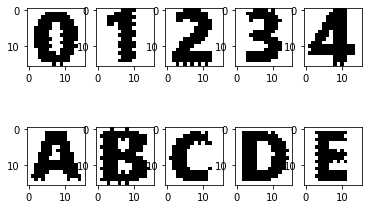

In [3]:
# Step 1
# Get the image and change every image to an 256-dimention vector
dataSet = np.zeros([10, 256])
f=lambda x: x + 60 if x > 4 else x + 48
for i in range(0, 10):
    # TODO Change PNG to jpg
    inputImageDir = './dataSet1/' + chr(f(i)) + str(1) + '.PNG'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
    plt.subplot(2,5,i+1)
    plt.imshow(inputImage)
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet[i] = array
dataSet = np.array(dataSet)

In [9]:
# Step 2
# define a neural network
class Perceptron(nn.Module):

    def __init__(self, input_size, d_hidden, num_classes):
        super(Perceptron, self).__init__()
        self.linear0 = nn.Linear(input_size, d_hidden[0])
        self.activate0 = nn.ReLU()
        self.linear1 = nn.Linear(d_hidden[0], d_hidden[1])
        self.activate1 = nn.ReLU()
        self.linear2 = nn.Linear(d_hidden[1], d_hidden[2])
        self.activate2 = nn.ReLU()
        self.linear3 = nn.Linear(d_hidden[2], d_hidden[3])
        self.activate3 = nn.ReLU()
        self.linear4 = nn.Linear(d_hidden[3],num_classes)
        self.activate4 = nn.Sigmoid()

        
    def forward(self, x):
        res = self.linear0(x)
        res = self.activate0(res)
        res = self.linear1(res)
        res = self.activate1(res)
        res = self.linear2(res)
        res = self.activate2(res)
        res = self.linear3(res)
        res = self.activate3(res)
        res = self.linear4(res)
        res = self.activate4(res)
        return res

In [10]:
class DigitDataset(Dataset):
    def __init__(self, dataset, label_list):
        self.dataset = dataset
        self.label_list = label_list
    def __len__(self):
        return len(self.label_list)
    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.label_list[idx]
        return {
            'data': torch.from_numpy(data).float(),
            'label': torch.from_numpy(label).float()
        }

In [11]:
# Parameters of training
learning_rate = 0.001
# Train until the error become the lowest
# get the optimization of MAE or MSE
num_epochs = 600
batch_size, input_size, num_classes = 10, 256, 256
d_hidden=[320, 320, 320, 320]

# Load the dataset
train_dataset = DigitDataset(dataset = dataSet, label_list = dataSet)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cpu')
model = Perceptron(input_size=input_size, d_hidden=d_hidden,num_classes=num_classes).to(device)

# Setup for noise training
if not os.path.exists('./models22'):
    os.mkdir('./models22')
torch.save(model, './models22/net_untrained.pkl')
for i in range(5):
    if not os.path.exists('./models22/' + str(i) + '/'):
        os.mkdir('./models22/' + str(i) + '/')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [12]:
# Step 3
model = Perceptron(input_size=input_size, d_hidden=d_hidden, num_classes=num_classes).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
def train(dataloader, model, num_epochs):
    # research regarding epoch to explain why we need that many iterations (num_epochs)
    for epoch in range(num_epochs):
        losses = []
        ERROR_Train = []
        model.train() 
        for i, data in enumerate(dataloader, 0):
            model.zero_grad()
            # data['data'] is each image data in dataset
            real_cpu, label_cpu = data['data'], data['label']
#             if torch.cuda.is_available():
#                 real_cpu = real_cpu.cuda() 
#                 label_cpu = label_cpu.cuda()
            real = real_cpu
            label = label_cpu
            inputv = Variable(real)
            labelv = Variable(label)
            output = model(inputv)
            err = criterion(output, labelv) 
            err.backward() 
            optimizer.step() 

            losses.append(err.data.item())
            error = label - output.data
#             print(error.shape)
            ERROR_Train.extend(error)
#         print(ERROR_Train)
        MAE = torch.mean(torch.abs(torch.stack(ERROR_Train)))
        ME = torch.mean(torch.stack(ERROR_Train))
        STD = torch.std(torch.stack(ERROR_Train)) 
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print('[%d/%d] Loss: %.4f MAE: %.4f Mean Error: %.4f STD: %.4f' % (epoch, num_epochs, np.average(losses), MAE, ME, STD))
    return output, model

# Start training        
output, model = train(train_loader, model, num_epochs)
# print(output.type)

[0/600] Loss: 0.2504 MAE: 0.5003 Mean Error: 0.0844 STD: 0.4933
[10/600] Loss: 0.1533 MAE: 0.2199 Mean Error: 0.0215 STD: 0.3911
[20/600] Loss: 0.1336 MAE: 0.2636 Mean Error: -0.0036 STD: 0.3656
[30/600] Loss: 0.1224 MAE: 0.2576 Mean Error: 0.0093 STD: 0.3499
[40/600] Loss: 0.0942 MAE: 0.1915 Mean Error: 0.0039 STD: 0.3069
[50/600] Loss: 0.0678 MAE: 0.1488 Mean Error: -0.0076 STD: 0.2603
[60/600] Loss: 0.0458 MAE: 0.0981 Mean Error: -0.0048 STD: 0.2141
[70/600] Loss: 0.0256 MAE: 0.0637 Mean Error: -0.0031 STD: 0.1600
[80/600] Loss: 0.0111 MAE: 0.0310 Mean Error: -0.0016 STD: 0.1053
[90/600] Loss: 0.0053 MAE: 0.0138 Mean Error: -0.0012 STD: 0.0729
[100/600] Loss: 0.0041 MAE: 0.0078 Mean Error: -0.0008 STD: 0.0641
[110/600] Loss: 0.0037 MAE: 0.0060 Mean Error: -0.0004 STD: 0.0607
[120/600] Loss: 0.0036 MAE: 0.0052 Mean Error: -0.0003 STD: 0.0597
[130/600] Loss: 0.0035 MAE: 0.0047 Mean Error: -0.0004 STD: 0.0595
[140/600] Loss: 0.0035 MAE: 0.0045 Mean Error: -0.0004 STD: 0.0594
[150/600] 

(10, 256)


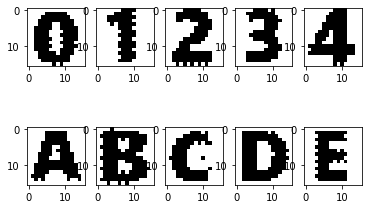

In [14]:
# Step 4
# Step 4a
# TODO create new for dataset 1
if not os.path.exists('./ass2output16'):
    os.mkdir('./ass2output16')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, './models22/net_trained.pkl')
output_dataset1 = np.zeros([10, 256])
for i in range(10):
    output_img = output_np[i].reshape(16, 16)*255
    img = Image.fromarray(np.uint8(output_img))
    img = img.convert("1")
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    output_path = './ass2output16/' + str(i) + '.png'
    img.save(output_path)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset1[i] = array


(10, 256)


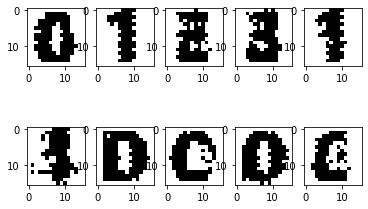

In [15]:
# Step 4
# Step 4b
# Export the image after training
# Before executing this block, create a folder called "output"

# read dataset2 images
dataSet2 = np.zeros([10, 256])
f=lambda x: x + 60 if x > 4 else x + 48
for i in range(0, 10):
    # TODO Change PNG to jpg
    inputImageDir = './dataSet2/' + chr(f(i)) + str(2) + '.jpg'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
#     plt.subplot(6,6,i+1)
#     plt.imshow(inputImage)
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet2[i] = array
dataSet2 = np.array(dataSet2)

if not os.path.exists('./ass2output162'):
    os.mkdir('./ass2output162')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, './models22/net_trained.pkl')
output_dataset2 = np.zeros([10, 256])
output_dataset2_model = model(torch.from_numpy(dataSet2).float())
output_np = output_dataset2_model.detach().numpy()
for i in range(10):
    output_img = output_np[i].reshape(16, 16)*255
    img = Image.fromarray(np.uint8(output_img))
    img = img.convert("1")
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    output_path2 = './ass2output162/' + str(i) + '.png'
    img.save(output_path2)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset2[i] = array

In [16]:
# Calculate Fh
def calculateFh(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Fh_denominator = 0    # Fh分母
    Fh_numerator = 0      # Fh分子
    Fh_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 0:
                Fh_denominator = Fh_denominator + 1
                if output_dataset[j][i] == 0:
                    Fh_numerator = Fh_numerator + 1
        Fh = Fh_numerator / Fh_denominator
        Fh_array[j] = Fh
    return Fh_array

In [17]:
# Calculate Ffa
def calculateFfa(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Ffa_denominator = 0    # Ffa分母
    Ffa_numerator = 0      # Ffa分子
    Ffa_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 1:
                Ffa_denominator = Ffa_denominator + 1
            if output_dataset[j][i] == 0 and input_dataset[j][i] == 1:
                Ffa_numerator = Ffa_numerator + 1
        Ffa = Ffa_numerator / Ffa_denominator
        Ffa_array[j] = Ffa
    return Ffa_array

In [18]:
Fh_array1 = calculateFh(dataSet, output_dataset1)
Ffa_array1 = calculateFfa(dataSet, output_dataset1)
Fh_array2 = calculateFh(dataSet2, output_dataset2)
Ffa_array2 = calculateFfa(dataSet2, output_dataset2)
print(Fh_array2)
print(Ffa_array2)

[0.91566265 0.90510949 0.8647343  0.85714286 0.84164223 0.81105991
 0.81461676 0.81435257 0.81889764 0.79835873]
[0.20809249 0.16       0.18181818 0.1922043  0.18210863 0.18239564
 0.18277823 0.1840796  0.18223087 0.18394845]


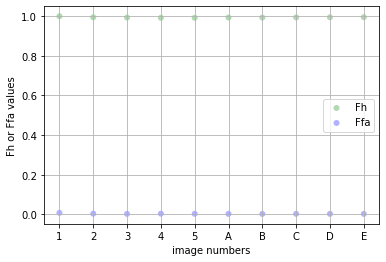

In [19]:
# TODO: Step 4c: Answer 2 questions from canvas
# Q1 Yes there is mismatch
# Q2 Should we compare Dataset2 output vs Dataset1 input? 50-50
# Why or why not?  (Justify your answer with analysis in the report generated in Step 8, below, and think about test, training, and validation datasets).
# TODO visualize Y' (dataset2 output) with X (dataset1 input) to Justify answer (think about test, training)

# Step 4d Graph Fh as a function of Ffa for each exemplar in the input dataset
# Graph for dataset1
import numpy as np
import matplotlib.pyplot as plt

#std_plot = [[i for _ in range(10)] for i in std]
# noiseless
fig, ax = plt.subplots()

Image_name = ['1','2','3','4','5','A','B','C','D','E']
#print(len(Image_name))
#print(len(Ffa_array))
# ax.scatter([1,2,3,4,5,6,7,8,9,10], Fh_array, c="green", label="Fh", alpha=0.3, edgecolors='none')
# ax.scatter([1,2,3,4,5,6,7,8,9,10], Ffa_array, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.scatter(Image_name, Fh_array1, c="green", label="Fh", alpha=0.3, edgecolors='none')
ax.scatter(Image_name, Ffa_array1, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.legend()
ax.grid(True)
plt.xlabel("image numbers")
plt.ylabel("Fh or Ffa values")
# plt.yscale("log")
plt.show()


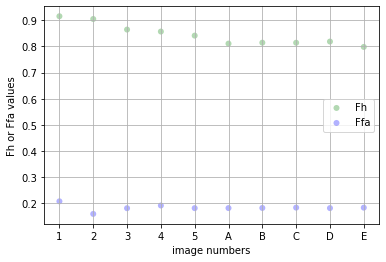

In [20]:
# Graph for dataset2
#std_plot = [[i for _ in range(10)] for i in std]
# noiseless
fig, ax = plt.subplots()

Image_name = ['1','2','3','4','5','A','B','C','D','E']
#print(len(Image_name))
#print(len(Ffa_array))
# ax.scatter([1,2,3,4,5,6,7,8,9,10], Fh_array, c="green", label="Fh", alpha=0.3, edgecolors='none')
# ax.scatter([1,2,3,4,5,6,7,8,9,10], Ffa_array, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.scatter(Image_name, Fh_array2, c="green", label="Fh", alpha=0.3, edgecolors='none')
ax.scatter(Image_name, Ffa_array2, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.legend()
ax.grid(True)
plt.xlabel("image numbers")
plt.ylabel("Fh or Ffa values")
# plt.yscale("log")
plt.show()

In [ ]:
# Step 5
def gaussian_noise(img, mean, sigma, percentage):
    # Generate gauss noise
    print(img)
    gaussian_out=img
    noise = np.random.normal(mean, sigma, int(percentage*input_size))
    # Add the noise to image
    gp = np.random.uniform(0,255,int(percentage*input_size))
    for i in range(int(percentage*input_size)):
        if gaussian_out[int(gp[i])]==1:
            gaussian_out[int(gp[i])]-=abs(noise[i])
        else:
            gaussian_out[int(gp[i])]+=abs(noise[i])
    #gaussian_out = img + noise
    # Make the value between 0 and 1
    return gaussian_out

gaussian_dataset = np.zeros([5, 9, 10, 256])
std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
perc = [0.1, 0.2, 0.25, 0.3, 0.35]

if not os.path.exists('./input_noise23/'):
        os.mkdir('./input_noise23/')
for k in range(5):
    if not os.path.exists('./input_noise23/'+ str(perc[k]) + '/' ):
        os.mkdir('./input_noise23/' + str(perc[k]) + '/' )

for k in range(5):
    for j in range(9):
        if not os.path.exists('./input_noise23/' + str(perc[k]) + '/' + str(std[j])):
            os.mkdir('./input_noise23/' + str(perc[k]) + '/' + str(std[j]))
        for i in range(10):
            inputImage = dataSet2[i].copy()
            gaussian_data = gaussian_noise(inputImage, 0, std[j], perc[k])
            img = gaussian_data.reshape(16, 16)*255
            img = Image.fromarray(np.uint8(img))
            img.convert("1")
            
            inputImageDir = './input_noise22/' + str(perc[k]) + '/' + str(std[j]) + '/' + str(i) + '.png'
            img.save(inputImageDir)
            gaussian_dataset[k][j][i] = gaussian_data
gaussian_dataset = np.array(gaussian_dataset)

Fh_noise_array = np.zeros([5, 9, 10])
Ffa_noise_array = np.zeros([5, 9, 10])

# Train 9 datasets with noise
if not os.path.exists('./output_noise23/'):
        os.mkdir('./output_noise23/')
for k in range(5):
    if not os.path.exists('./output_noise23/' + str(perc[k]) + '/'):
        os.mkdir('./output_noise23/' + str(perc[k]) + '/')
for k in range(5):
    for j in range(9):
        train_noise_dataset = DigitDataset(dataset = gaussian_dataset[k][j], label_list = dataSet)
        train_noise_loader = DataLoader(dataset=train_noise_dataset, batch_size=batch_size, shuffle=False)
        print('Training dataset with noise standard deviation ' + str(std[j]))
    #     model_noise = torch.load('./models/net_untrained.pkl') #  Load the model that trained before
        model_noise = Perceptron(input_size=input_size, d_hidden = d_hidden, num_classes=num_classes).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model_noise.parameters(), lr=learning_rate)

        output_noise, model_noise = train(train_noise_loader, model_noise, num_epochs)   # Train
        torch.save(model_noise, './models22/' + str(k) + '/' + 'net_trained_' + str(std[j]) + '.pkl')
        model_noise = torch.load('./models22/' + str(k) + '/' + 'net_trained_'+ str(std[j]) + '.pkl')
    #     output_noise = model_noise(torch.from_numpy(gaussian_dataset[j]).float()) # Use the model trained before to test
        print('------------------------------------')
        output_noise = model_noise(torch.from_numpy(dataSet).float())
        output_noise_np = output_noise.detach().numpy()     # Get the output
    #     print(output_noise_np)
        output_noise_dataset = np.zeros([10, 256])
    #     Make the output only has 0 or 1

        if not os.path.exists('./output_noise23/' + str(perc[k]) + '/' + str(std[j])):
            os.mkdir('./output_noise23/' + str(perc[k]) + '/' + str(std[j]))
    
    
        for i in range(10):
            output_noise_img = output_noise_np[i].reshape(16, 16)*255
            img = Image.fromarray(np.uint8(output_noise_img))
            img = img.convert("1")
            output_path = './output_noise23/' + str(perc[k]) + '/' + str(std[j]) + '/' + str(i) + '.png'
            img.save(output_path)
            data = img.getdata()
            array = np.array(data)/255
            output_noise_dataset[i] = array
#     Calculate Fh and Ffa
    #Fh = calculateFh(dataSet, output_noise_dataset)
    #Ffa = calculateFfa(dataSet, output_noise_dataset)
    #Fh_noise_array[j] = Fh
    #Ffa_noise_array[j] = Ffa
print('------------Fh_noise_array------------')
print(Fh_noise_array)
print('------------Ffa_noise_array------------')
print(Ffa_noise_array)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.
 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 

[40/600] Loss: 0.0855 MAE: 0.1797 Mean Error: -0.0028 STD: 0.2925
[50/600] Loss: 0.0694 MAE: 0.1478 Mean Error: -0.0044 STD: 0.2635
[60/600] Loss: 0.0485 MAE: 0.1113 Mean Error: -0.0027 STD: 0.2202
[70/600] Loss: 0.0267 MAE: 0.0647 Mean Error: -0.0021 STD: 0.1634
[80/600] Loss: 0.0123 MAE: 0.0310 Mean Error: -0.0021 STD: 0.1107
[90/600] Loss: 0.0068 MAE: 0.0147 Mean Error: -0.0021 STD: 0.0823
[100/600] Loss: 0.0056 MAE: 0.0095 Mean Error: -0.0018 STD: 0.0746
[110/600] Loss: 0.0050 MAE: 0.0077 Mean Error: -0.0023 STD: 0.0705
[120/600] Loss: 0.0046 MAE: 0.0068 Mean Error: -0.0020 STD: 0.0677
[130/600] Loss: 0.0043 MAE: 0.0060 Mean Error: -0.0019 STD: 0.0659
[140/600] Loss: 0.0043 MAE: 0.0057 Mean Error: -0.0020 STD: 0.0657
[150/600] Loss: 0.0043 MAE: 0.0054 Mean Error: -0.0019 STD: 0.0657
[160/600] Loss: 0.0043 MAE: 0.0053 Mean Error: -0.0019 STD: 0.0656
[170/600] Loss: 0.0040 MAE: 0.0051 Mean Error: -0.0014 STD: 0.0631
[180/600] Loss: 0.0039 MAE: 0.0049 Mean Error: -0.0015 STD: 0.0626
[

[50/600] Loss: 0.0686 MAE: 0.1491 Mean Error: -0.0068 STD: 0.2618
[60/600] Loss: 0.0407 MAE: 0.0962 Mean Error: -0.0065 STD: 0.2017
[70/600] Loss: 0.0176 MAE: 0.0443 Mean Error: -0.0033 STD: 0.1328
[80/600] Loss: 0.0086 MAE: 0.0196 Mean Error: -0.0023 STD: 0.0929
[90/600] Loss: 0.0062 MAE: 0.0107 Mean Error: -0.0017 STD: 0.0787
[100/600] Loss: 0.0053 MAE: 0.0077 Mean Error: -0.0022 STD: 0.0727
[110/600] Loss: 0.0051 MAE: 0.0065 Mean Error: -0.0020 STD: 0.0715
[120/600] Loss: 0.0051 MAE: 0.0061 Mean Error: -0.0020 STD: 0.0713
[130/600] Loss: 0.0051 MAE: 0.0060 Mean Error: -0.0020 STD: 0.0713
[140/600] Loss: 0.0051 MAE: 0.0059 Mean Error: -0.0020 STD: 0.0713
[150/600] Loss: 0.0051 MAE: 0.0058 Mean Error: -0.0020 STD: 0.0713
[160/600] Loss: 0.0051 MAE: 0.0058 Mean Error: -0.0020 STD: 0.0713
[170/600] Loss: 0.0051 MAE: 0.0058 Mean Error: -0.0020 STD: 0.0713
[180/600] Loss: 0.0051 MAE: 0.0057 Mean Error: -0.0020 STD: 0.0713
[190/600] Loss: 0.0051 MAE: 0.0057 Mean Error: -0.0019 STD: 0.0712


[40/600] Loss: 0.0907 MAE: 0.1839 Mean Error: -0.0049 STD: 0.3011
[50/600] Loss: 0.0693 MAE: 0.1510 Mean Error: -0.0030 STD: 0.2632
[60/600] Loss: 0.0451 MAE: 0.1031 Mean Error: -0.0006 STD: 0.2124
[70/600] Loss: 0.0227 MAE: 0.0566 Mean Error: -0.0028 STD: 0.1508
[80/600] Loss: 0.0092 MAE: 0.0237 Mean Error: -0.0009 STD: 0.0960
[90/600] Loss: 0.0057 MAE: 0.0117 Mean Error: -0.0013 STD: 0.0752
[100/600] Loss: 0.0046 MAE: 0.0078 Mean Error: -0.0013 STD: 0.0682
[110/600] Loss: 0.0040 MAE: 0.0059 Mean Error: -0.0017 STD: 0.0631
[120/600] Loss: 0.0039 MAE: 0.0052 Mean Error: -0.0016 STD: 0.0627
[130/600] Loss: 0.0039 MAE: 0.0049 Mean Error: -0.0017 STD: 0.0626
[140/600] Loss: 0.0039 MAE: 0.0048 Mean Error: -0.0016 STD: 0.0626
[150/600] Loss: 0.0039 MAE: 0.0047 Mean Error: -0.0016 STD: 0.0625
[160/600] Loss: 0.0039 MAE: 0.0046 Mean Error: -0.0016 STD: 0.0625
[170/600] Loss: 0.0039 MAE: 0.0046 Mean Error: -0.0016 STD: 0.0625
[180/600] Loss: 0.0039 MAE: 0.0045 Mean Error: -0.0016 STD: 0.0625
[

[40/600] Loss: 0.0959 MAE: 0.1945 Mean Error: 0.0008 STD: 0.3098
[50/600] Loss: 0.0761 MAE: 0.1623 Mean Error: -0.0056 STD: 0.2758
[60/600] Loss: 0.0465 MAE: 0.1065 Mean Error: -0.0055 STD: 0.2155
[70/600] Loss: 0.0218 MAE: 0.0504 Mean Error: -0.0011 STD: 0.1477
[80/600] Loss: 0.0120 MAE: 0.0232 Mean Error: -0.0017 STD: 0.1095
[90/600] Loss: 0.0088 MAE: 0.0137 Mean Error: 0.0005 STD: 0.0939
[100/600] Loss: 0.0083 MAE: 0.0105 Mean Error: 0.0005 STD: 0.0910
[110/600] Loss: 0.0082 MAE: 0.0097 Mean Error: 0.0003 STD: 0.0907
[120/600] Loss: 0.0082 MAE: 0.0093 Mean Error: 0.0004 STD: 0.0905
[130/600] Loss: 0.0078 MAE: 0.0090 Mean Error: 0.0001 STD: 0.0885
[140/600] Loss: 0.0078 MAE: 0.0089 Mean Error: -0.0001 STD: 0.0885
[150/600] Loss: 0.0075 MAE: 0.0085 Mean Error: -0.0004 STD: 0.0864
[160/600] Loss: 0.0074 MAE: 0.0084 Mean Error: -0.0003 STD: 0.0862
[170/600] Loss: 0.0074 MAE: 0.0082 Mean Error: -0.0004 STD: 0.0862
[180/600] Loss: 0.0071 MAE: 0.0079 Mean Error: -0.0000 STD: 0.0840
[190/60

[30/600] Loss: 0.1125 MAE: 0.2416 Mean Error: 0.0034 STD: 0.3355
[40/600] Loss: 0.0928 MAE: 0.1831 Mean Error: -0.0018 STD: 0.3046
[50/600] Loss: 0.0776 MAE: 0.1639 Mean Error: -0.0035 STD: 0.2786
[60/600] Loss: 0.0574 MAE: 0.1284 Mean Error: -0.0069 STD: 0.2396
[70/600] Loss: 0.0288 MAE: 0.0721 Mean Error: -0.0037 STD: 0.1698
[80/600] Loss: 0.0125 MAE: 0.0303 Mean Error: -0.0051 STD: 0.1119
[90/600] Loss: 0.0076 MAE: 0.0155 Mean Error: -0.0044 STD: 0.0871
[100/600] Loss: 0.0051 MAE: 0.0094 Mean Error: -0.0037 STD: 0.0716
[110/600] Loss: 0.0044 MAE: 0.0067 Mean Error: -0.0033 STD: 0.0666
[120/600] Loss: 0.0043 MAE: 0.0058 Mean Error: -0.0035 STD: 0.0657
[130/600] Loss: 0.0043 MAE: 0.0055 Mean Error: -0.0035 STD: 0.0656
[140/600] Loss: 0.0043 MAE: 0.0053 Mean Error: -0.0035 STD: 0.0656
[150/600] Loss: 0.0043 MAE: 0.0052 Mean Error: -0.0035 STD: 0.0655
[160/600] Loss: 0.0043 MAE: 0.0051 Mean Error: -0.0035 STD: 0.0655
[170/600] Loss: 0.0043 MAE: 0.0051 Mean Error: -0.0035 STD: 0.0655
[18

[70/600] Loss: 0.0211 MAE: 0.0504 Mean Error: 0.0025 STD: 0.1451
[80/600] Loss: 0.0084 MAE: 0.0220 Mean Error: -0.0011 STD: 0.0914
[90/600] Loss: 0.0056 MAE: 0.0111 Mean Error: -0.0023 STD: 0.0746
[100/600] Loss: 0.0044 MAE: 0.0078 Mean Error: -0.0016 STD: 0.0661
[110/600] Loss: 0.0037 MAE: 0.0062 Mean Error: -0.0011 STD: 0.0612
[120/600] Loss: 0.0036 MAE: 0.0052 Mean Error: -0.0012 STD: 0.0597
[130/600] Loss: 0.0035 MAE: 0.0047 Mean Error: -0.0012 STD: 0.0595
[140/600] Loss: 0.0035 MAE: 0.0045 Mean Error: -0.0012 STD: 0.0594
[150/600] Loss: 0.0035 MAE: 0.0044 Mean Error: -0.0012 STD: 0.0594
[160/600] Loss: 0.0035 MAE: 0.0043 Mean Error: -0.0012 STD: 0.0594
[170/600] Loss: 0.0035 MAE: 0.0043 Mean Error: -0.0012 STD: 0.0593
[180/600] Loss: 0.0035 MAE: 0.0042 Mean Error: -0.0012 STD: 0.0593
[190/600] Loss: 0.0035 MAE: 0.0042 Mean Error: -0.0012 STD: 0.0593
[200/600] Loss: 0.0035 MAE: 0.0042 Mean Error: -0.0012 STD: 0.0593
[210/600] Loss: 0.0035 MAE: 0.0041 Mean Error: -0.0012 STD: 0.0593

[60/600] Loss: 0.0486 MAE: 0.1099 Mean Error: -0.0028 STD: 0.2206
[70/600] Loss: 0.0248 MAE: 0.0570 Mean Error: -0.0031 STD: 0.1576
[80/600] Loss: 0.0136 MAE: 0.0289 Mean Error: -0.0028 STD: 0.1165
[90/600] Loss: 0.0090 MAE: 0.0165 Mean Error: -0.0034 STD: 0.0948
[100/600] Loss: 0.0076 MAE: 0.0112 Mean Error: -0.0035 STD: 0.0874
[110/600] Loss: 0.0075 MAE: 0.0095 Mean Error: -0.0034 STD: 0.0865
[120/600] Loss: 0.0074 MAE: 0.0089 Mean Error: -0.0035 STD: 0.0862
[130/600] Loss: 0.0074 MAE: 0.0086 Mean Error: -0.0035 STD: 0.0862
[140/600] Loss: 0.0074 MAE: 0.0085 Mean Error: -0.0035 STD: 0.0862
[150/600] Loss: 0.0074 MAE: 0.0084 Mean Error: -0.0035 STD: 0.0862
[160/600] Loss: 0.0074 MAE: 0.0083 Mean Error: -0.0035 STD: 0.0862
[170/600] Loss: 0.0074 MAE: 0.0083 Mean Error: -0.0035 STD: 0.0861
[180/600] Loss: 0.0074 MAE: 0.0083 Mean Error: -0.0035 STD: 0.0861
[190/600] Loss: 0.0074 MAE: 0.0082 Mean Error: -0.0035 STD: 0.0861
[200/600] Loss: 0.0074 MAE: 0.0082 Mean Error: -0.0035 STD: 0.0861

[70/600] Loss: 0.0178 MAE: 0.0454 Mean Error: 0.0009 STD: 0.1334
[80/600] Loss: 0.0081 MAE: 0.0180 Mean Error: -0.0000 STD: 0.0897
[90/600] Loss: 0.0059 MAE: 0.0104 Mean Error: 0.0007 STD: 0.0771
[100/600] Loss: 0.0053 MAE: 0.0077 Mean Error: 0.0004 STD: 0.0728
[110/600] Loss: 0.0051 MAE: 0.0065 Mean Error: 0.0004 STD: 0.0715
[120/600] Loss: 0.0051 MAE: 0.0061 Mean Error: 0.0004 STD: 0.0713
[130/600] Loss: 0.0047 MAE: 0.0057 Mean Error: 0.0001 STD: 0.0687
[140/600] Loss: 0.0047 MAE: 0.0056 Mean Error: -0.0000 STD: 0.0686
[150/600] Loss: 0.0047 MAE: 0.0054 Mean Error: 0.0000 STD: 0.0685
[160/600] Loss: 0.0047 MAE: 0.0054 Mean Error: 0.0000 STD: 0.0685
[170/600] Loss: 0.0047 MAE: 0.0053 Mean Error: 0.0000 STD: 0.0685
[180/600] Loss: 0.0047 MAE: 0.0053 Mean Error: 0.0000 STD: 0.0685
[190/600] Loss: 0.0047 MAE: 0.0053 Mean Error: 0.0000 STD: 0.0685
[200/600] Loss: 0.0047 MAE: 0.0052 Mean Error: 0.0000 STD: 0.0685
[210/600] Loss: 0.0047 MAE: 0.0052 Mean Error: 0.0000 STD: 0.0685
[220/600] L

[80/600] Loss: 0.0082 MAE: 0.0215 Mean Error: -0.0010 STD: 0.0906
[90/600] Loss: 0.0046 MAE: 0.0111 Mean Error: -0.0010 STD: 0.0682
[100/600] Loss: 0.0033 MAE: 0.0065 Mean Error: -0.0009 STD: 0.0578
[110/600] Loss: 0.0032 MAE: 0.0050 Mean Error: -0.0008 STD: 0.0563
[120/600] Loss: 0.0031 MAE: 0.0045 Mean Error: -0.0007 STD: 0.0561
[130/600] Loss: 0.0031 MAE: 0.0042 Mean Error: -0.0008 STD: 0.0560
[140/600] Loss: 0.0031 MAE: 0.0041 Mean Error: -0.0008 STD: 0.0560
[150/600] Loss: 0.0029 MAE: 0.0040 Mean Error: -0.0011 STD: 0.0537
[160/600] Loss: 0.0028 MAE: 0.0039 Mean Error: -0.0011 STD: 0.0524
[170/600] Loss: 0.0027 MAE: 0.0037 Mean Error: -0.0011 STD: 0.0524
[180/600] Loss: 0.0027 MAE: 0.0036 Mean Error: -0.0011 STD: 0.0524
[190/600] Loss: 0.0027 MAE: 0.0035 Mean Error: -0.0012 STD: 0.0524
[200/600] Loss: 0.0027 MAE: 0.0035 Mean Error: -0.0012 STD: 0.0523
[210/600] Loss: 0.0027 MAE: 0.0035 Mean Error: -0.0012 STD: 0.0523
[220/600] Loss: 0.0027 MAE: 0.0034 Mean Error: -0.0012 STD: 0.05

In [ ]:
# Remoaining 
# 1. 32x32
# 2. noise visualization
# 3. 4c Questions
